In [2]:
import pandas as pd, numpy as np
import warnings
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
import seaborn as sns
import matplotlib.pyplot as plt


## Reading the data
dtypes = { 'Unnamed: 0': 'int32', 'drugName': 'category', 'condition': 'category', 'review': 'category', 'rating': 'float16', 'date': 'category', 'usefulCount': 'int16' }
train_df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t', dtype=dtypes)
# Randomly selecting 80% of the data from the training dataset
train_df = train_df.sample(frac=0.8, random_state=42)
test_df = pd.read_csv('drugsComTest_raw.tsv', sep='\t', dtype=dtypes)

## Converting date column to datetime format
train_df['date'], test_df['date'] = pd.to_datetime(train_df['date'], format='%B %d, %Y'), pd.to_datetime(test_df['date'], format='%B %d, %Y')

## Extracting day, month, and year into separate columns
for df in [train_df, test_df]:
    df['day'] = df['date'].dt.day.astype('int8')
    df['month'] = df['date'].dt.month.astype('int8')
    df['year'] = df['date'].dt.year.astype('int16')



In [3]:
test_df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,day,month,year
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,28,2,2012
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,17,5,2009
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,29,9,2017
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,5,3,2017
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,22,10,2015
...,...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,2014-09-13,43,13,9,2014
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,2016-10-08,11,8,10,2016
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,2010-11-15,7,15,11,2010
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,2011-11-28,20,28,11,2011


In [4]:
import xgboost

In [5]:
## Suppressing MarkupResemblesLocatorWarning, FutureWarning and ConvergenceWarning
warnings.filterwarnings('ignore', category=MarkupResemblesLocatorWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Defining function to decode HTML-encoded characters
def decode_html(text):
    decoded_text = BeautifulSoup(text, 'html.parser').get_text()
    return decoded_text

## Applying the function to the review column
train_df['review'], test_df['review'] = train_df['review'].apply(decode_html), test_df['review'].apply(decode_html)

## Dropped the original date column and removed the useless column
train_df, test_df = [df.drop('date', axis=1).drop(df.columns[0], axis=1) for df in (train_df, test_df)]

## Handling the missing values
train_imp, test_imp = [pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df)) for df in (train_df, test_df)]

## Assigning old column names
train_imp.columns = ['drugName', 'condition', 'review', 'rating', 'usefulCount', 'day', 'month', 'year']
test_imp.columns = ['drugName', 'condition', 'review', 'rating', 'usefulCount', 'day', 'month', 'year']



In [6]:
train_imp

,drugName,condition,review,rating,usefulCount,day,month,year
0,Phentermine,Weight Loss,"""I started taking Phentermine just a little ov...",10.0,24,26,11,2016
1,Desvenlafaxine,Depression,"""I have had depression for years due to situat...",10.0,31,25,7,2009
2,Leuprolide,Endometriosis,"""I was actually surprised to learn I had stage...",8.0,31,21,12,2011
3,Zyclara,Keratosis,"""Have used this for one week but began to have...",7.0,17,20,1,2013
4,Diphenhydramine,Allergic Reactions,"""Experienced an allergic reaction during dinne...",10.0,20,11,4,2015
...,...,...,...,...,...,...,...,...
129033,Skyla,Birth Control,"""I have had the Skyla for about a year now and...",9.0,4,4,7,2016
129034,Liletta,Birth Control,"""I LOVE MIRENA. My doctor (who must work for ...",1.0,9,6,1,2017
129035,Estarylla,Birth Control,"""I've been on it for 3 years with 0 side effec...",9.0,8,8,10,2016
129036,Aluminum chloride hexahydrate,Hyperhidrosis,"""This was like a miracle prescription! Works g...",10.0,13,9,2,2015


In [7]:
test_imp

,drugName,condition,review,rating,usefulCount,day,month,year
0,Mirtazapine,Depression,"""I've tried a few antidepressants over the yea...",10.0,22,28,2,2012
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn's disease and has done very ...",8.0,17,17,5,2009
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,3,29,9,2017
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,35,5,3,2017
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,4,22,10,2015
...,...,...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,43,13,9,2014
53762,Escitalopram,Anxiety,"""I've been taking Lexapro (escitaploprgram) si...",9.0,11,8,10,2016
53763,Levonorgestrel,Birth Control,"""I'm married, 34 years old and I have no kids....",8.0,7,15,11,2010
53764,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,20,28,11,2011


In [8]:
## Converting the text in the review column to numerical data
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
train_reviews = vectorizer.fit_transform(train_imp['review'])
test_reviews = vectorizer.transform(test_imp['review'])

## Replacing the review column with the numerical data
train_imp.drop('review', axis=1, inplace=True)
test_imp.drop('review', axis=1, inplace=True)
train_imp = pd.concat([train_imp, pd.DataFrame(train_reviews.toarray())], axis=1)
test_imp = pd.concat([test_imp, pd.DataFrame(test_reviews.toarray())], axis=1)

## Encoding the categorical columns
for i in ["drugName", "condition"]:
    train_imp[i] = LabelEncoder().fit_transform(train_imp[i])
    test_imp[i] = LabelEncoder().fit_transform(test_imp[i])

## Converting the data types of columns to reduce the memory usage
train_imp, test_imp = train_imp.astype('float16'), test_imp.astype('float16')
train_imp[['drugName', 'condition', 'usefulCount', 'year']] = train_imp[['drugName', 'condition', 'usefulCount', 'year']].astype('int16')
test_imp[['drugName', 'condition', 'usefulCount', 'year']] = test_imp[['drugName', 'condition', 'usefulCount', 'year']].astype('int16')
train_imp[['rating']] = train_imp[['rating']].astype('float16')
test_imp[['rating']] = test_imp[['rating']].astype('float16')
train_imp[['day', 'month']] = train_imp[['day', 'month']].astype('int8')
test_imp[['day', 'month']] = test_imp[['day', 'month']].astype('int8')

print(train_imp.iloc[:,:15].dtypes)
print(test_imp.iloc[:,:15].dtypes)



drugName         int16
condition        int16
rating         float16
usefulCount      int16
day               int8
month             int8
year             int16
0              float16
1              float16
2              float16
3              float16
4              float16
5              float16
6              float16
7              float16
dtype: object
drugName         int16
condition        int16
rating         float16
usefulCount      int16
day               int8
month             int8
year             int16
0              float16
1              float16
2              float16
3              float16
4              float16
5              float16
6              float16
7              float16
dtype: object


In [9]:
## Splitting the train and test datasets into feature variables
X_train, Y_train = train_imp.drop('rating', axis=1), train_imp['rating']
X_test, Y_test = test_imp.drop('rating', axis=1), test_imp['rating']

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)


In [10]:
model.fit(X_train, Y_train)
xg_train=model.predict(X_train)
xg_test=model.predict(X_test)

print("Xgboost Metrics:")
print("MSE for training: ", mean_squared_error(Y_train, xg_train))
print("MSE for testing: ", mean_squared_error(Y_test, xg_test))
print("R2 score for training: ", r2_score(Y_train, xg_train))
print("R2 score for testing: ", r2_score(Y_test, xg_test))




KeyboardInterrupt: 

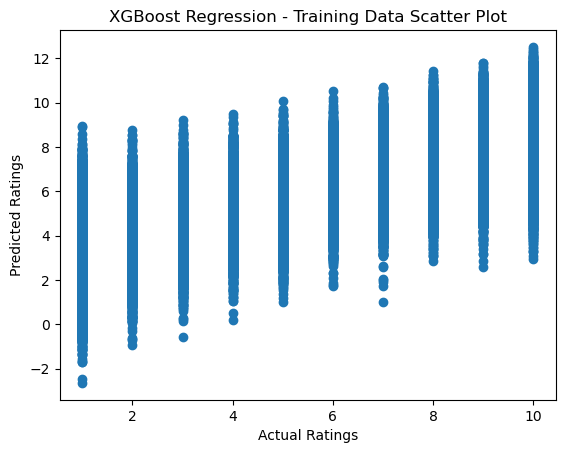

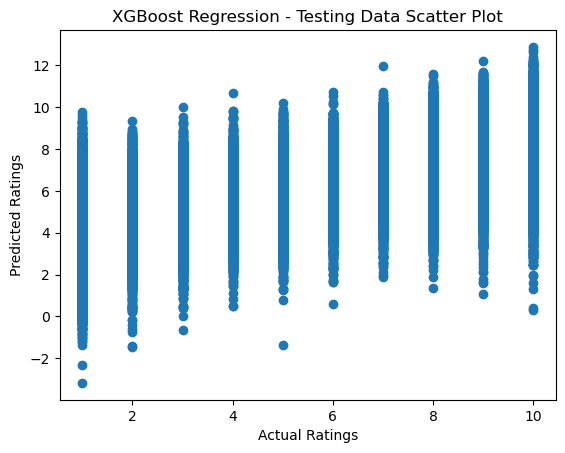

In [12]:
# Plotting the scatter plot of predicted vs actual values for training data
plt.scatter(Y_train, xg_train)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('XGBoost Regression - Training Data Scatter Plot')
plt.show()

# Plotting the scatter plot of predicted vs actual values for testing data
plt.scatter(Y_test, xg_test)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('XGBoost Regression - Testing Data Scatter Plot')
plt.show()

In [1]:
import lightgbm as lgb

In [11]:
from lightgbm import LGBMRegressor

In [12]:
lgbmodel = LGBMRegressor()

In [13]:
lgbmodel.fit(X_train, Y_train)
lgb_train=lgbmodel.predict(X_train)
lgb_test=lgbmodel.predict(X_test)

print("LGBM Metrics:")
print("MSE for training: ", mean_squared_error(Y_train, lgb_train))
print("MSE for testing: ", mean_squared_error(Y_test, lgb_test))
print("R2 score for training: ", r2_score(Y_train, lgb_train))
print("R2 score for testing: ", r2_score(Y_test, lgb_test))


LGBM Metrics:
MSE for training:  5.614266291975168
MSE for testing:  6.08444646567784
R2 score for training:  0.4762102373816558
R2 score for testing:  0.4362075610535959


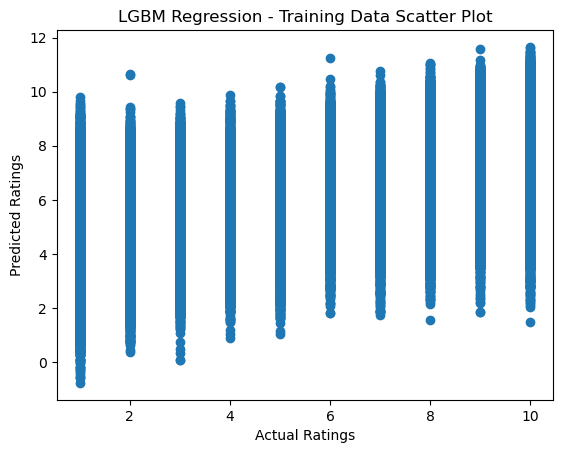

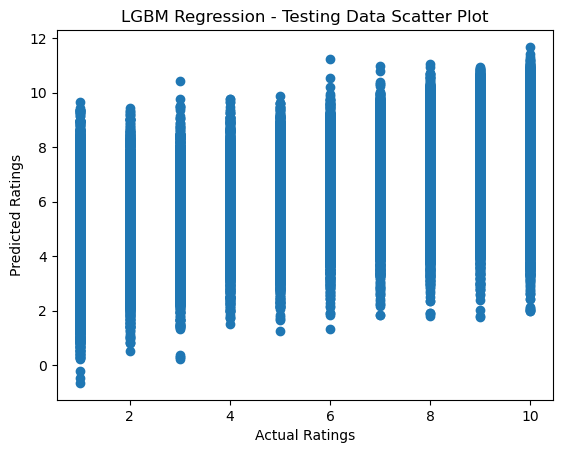

In [14]:
# Plotting the scatter plot of predicted vs actual values for training data
plt.scatter(Y_train, lgb_train)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('LGBM Regression - Training Data Scatter Plot')
plt.show()

# Plotting the scatter plot of predicted vs actual values for testing data
plt.scatter(Y_test, lgb_test)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('LGBM Regression - Testing Data Scatter Plot')
plt.show()

In [15]:
from sklearn import svm
svm_model = svm.SVR()

In [ ]:
svm_model.fit(X_train, Y_train)
svm_train=svm_model.predict(X_train)
svm_test=svm_model.predict(X_test)

print("SVM Regression Metrics:")
print("MSE for training: ", mean_squared_error(Y_train, svm_train))
print("MSE for testing: ", mean_squared_error(Y_test, svm_test))
print("R2 score for training: ", r2_score(Y_train, svm_train))
print("R2 score for testing: ", r2_score(Y_test, svm_test))


In [ ]:
# Plotting the scatter plot of predicted vs actual values for training data
plt.scatter(Y_train, svm_train)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('LGBM Regression - Training Data Scatter Plot')
plt.show()

# Plotting the scatter plot of predicted vs actual values for testing data
plt.scatter(Y_test, svm_test)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('LGBM Regression - Testing Data Scatter Plot')
plt.show()